In [2]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

import torch
torch.set_float32_matmul_precision('high')

In [3]:
# Import the relevant modules
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sousvide.synthesize.rollout_generator as rg
import sousvide.utilities.feature_utilities as fu
import figs.visualize.generate_videos as gv
from scipy.spatial.transform import Rotation as R
import figs.utilities.config_helper as ch
import figs.dynamics.quadcopter_specifications as qs
import figs.utilities.transform_helper as th

In [4]:
cohort = "features"
scene = "button1"
courses = ["button_arc"]

In [ ]:
def generate_Xdt(Ndt:int,p_tW:np.ndarray):
    # Some useful constants
    z_gW = np.array([0.0, 0.0, 1.0])

    # Generate the dataset
    Xdt = np.zeros((Ndt, 10))
    for i in range(Ndt):
        # Sample spherical coordinates
        x_cW = np.random.uniform(-1.0, 1.0)
        y_cW = np.random.uniform(-1.0, 1.0)
        z_cW = np.random.uniform(-0.2,-1.5)

        p_cW = np.array([x_cW, y_cW, z_cW])

        xb = p_tW-p_cW
        xb = xb/np.linalg.norm(xb)
        yb = np.cross(z_gW,xb)
        zb = np.cross(xb, yb)
        R_cW = np.array([xb, yb, zb]).T

        Xdt[i,0:3] = p_cW
        Xdt[i,6:10] = R.from_matrix(R_cW).as_quat()
    
    return Xdt

In [6]:
# Load Data
gsplat = ch.get_gsplat('button1')
bframe = ch.get_config('carl','frames')
bspecs = qs.generate_specifications(bframe)
camera = gsplat.generate_output_camera(bspecs["camera"])

Tc2b = bspecs["Tc2b"]
fx,fy = bframe["camera"]["fx"],bframe["camera"]["fy"]
cx,cy = bframe["camera"]["cx"],bframe["camera"]["cy"]
K = np.array([[fx,  0, cx],
              [ 0, fy, cy],
              [ 0,  0,  1]])

Tb2c = np.linalg.inv(Tc2b)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/button1/splatfacto/2025-05-31_134218/nerfstudio_models/step-000029999.ckpt

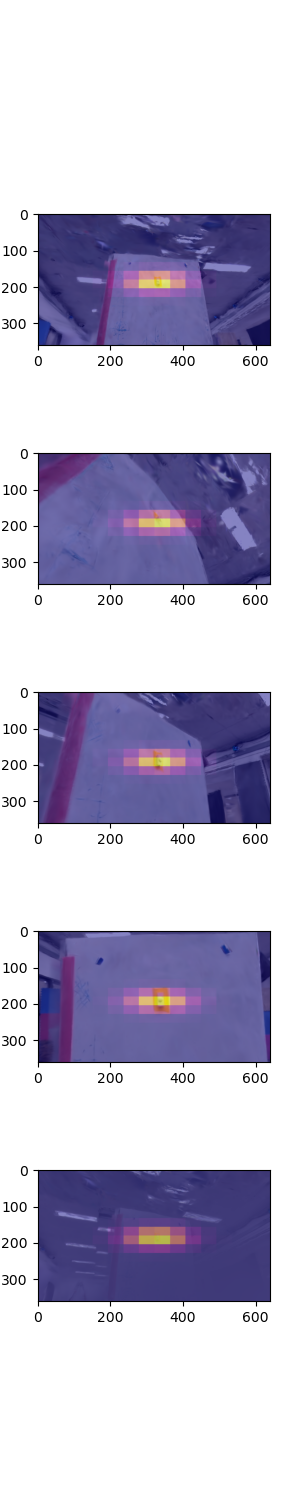

In [16]:
# Some useful constants
np.random.seed(1)

Np = 16
img_h, img_w = 360,640
pch_h, pch_w = img_h/Np, img_w/Np
pch_x = np.linspace(pch_w/2, img_w-pch_w/2, Np)
pch_y = np.linspace(pch_h/2, img_h-pch_h/2, Np)
sigma = 30.0

# Generate the camera poses
Ndt = 5
p_tW = np.array([ 0.03, -1.05, -1.20])
Xdt = generate_Xdt(Ndt, p_tW)

# Test the camera poses by plotting them
fig, ax = plt.subplots(Ndt, 1, figsize=(3, 15))

p_tW_h = np.ones((4,))
p_tW_h[0:3] = p_tW
for i in range(Ndt):
    # Get current image
    Tb2w = th.x_to_T(Xdt[i,:])
    Tc2w = Tb2w@Tc2b
    iro,_ = gsplat.render_rgb(camera,Tc2w)

    # Generate the overlay
    Ri = R.from_quat(Xdt[i,6:10]).as_matrix()
    ti = Xdt[i,0:3]

    Tb2w = np.eye(4)
    Tb2w[0:3,0:3] = Ri
    Tb2w[0:3,3] = ti
    Tw2b = np.linalg.inv(Tb2w)

    Tw2c = Tb2c@Tw2b
    p_tc_h = Tw2c@p_tW_h
    p_tc_h[1:3] = -p_tc_h[1:3]  # Flip y and z for camera frame
    p_tc = p_tc_h[0:3]

    uv = K@p_tc[0:3]
    uv = uv/uv[2]
    u,v = uv[0], uv[1]
    u,v = np.clip(u,0,img_w-1), np.clip(v,0,img_h-1)

    heat_ref = torch.zeros((Np,Np))
    for j in range(Np):
        for k in range(Np):
            heat_ref[j,k] = np.exp(-((pch_x[j]-u)**2 + (pch_y[k]-v)**2)/(2*sigma**2))

    overlay = fu.heatmap_overlay(heat_ref,iro)
    ax[i].imshow(overlay)

In [ ]:
# Load variables
Tro,Xro,Uro,Iro,Tc2b,K = fu.extract_rollout_data(cohort,courses[0])

Nro = Iro.shape[0]
Tb2c = np.linalg.inv(Tc2b)
gv.images_to_mp4(Iro,"base.mp4",fps=20)

In [ ]:
# Patch variables
Np = 128
image_h, image_w = 360,640
patch_h, patch_w = image_h/Np, image_w/Np

# Generate Images
Itt = np.zeros_like(Iro)
p_tW = np.array([ 0.03, -1.05, -1.20, 1.0])
# p_tW = np.array([ 0.00, -5.00, -1.00, 1.0])
for i in range(Nro):
    Ri = R.from_quat(Xro[i,6:10]).as_matrix()
    ti = Xro[i,0:3]

    Tb2w = np.eye(4)
    Tb2w[0:3,0:3] = Ri
    Tb2w[0:3,3] = ti
    Tw2b = np.linalg.inv(Tb2w)

    Tw2c = Tb2c@Tw2b
    p_tc = Tw2c@p_tW
    p_tc[1:3] = -p_tc[1:3]  # Flip y and z for camera frame

    uv = K@p_tc[0:3]
    uv = uv/uv[2]
    u,v = uv[0], uv[1]
    u,v = np.clip(u,0,image_w-1), np.clip(v,0,image_h-1)

    patch_col = int(u/patch_w)
    patch_row = int(v/patch_h)

    heat_ref = torch.zeros((Np,Np))
    heat_ref[patch_row,patch_col] = 1.0

    overlay = fu.heatmap_overlay(heat_ref,Iro[i])
    Itt[i] = overlay

gv.images_to_mp4(Itt,"test.mp4",fps=20)

In [ ]:
# Static Target on Live V
idx_rf = 10
threshold = 0.90
alpha = 0.2

heat_ref = torch.zeros((16,16))
heat_ref[14, 4] = heat_ref[13, 4] = heat_ref[12, 4] = heat_ref[11, 4] = 1
heat_ref[10, 4] = heat_ref[10, 5] = heat_ref[ 9, 5] = heat_ref[ 8, 5] = 1
heat_ref[13, 7] = heat_ref[12, 7] = heat_ref[11, 7] = heat_ref[10, 7] = 1
heat_ref[ 9, 6] = heat_ref[ 8, 6] = heat_ref[ 7, 6] = heat_ref[ 6, 6] = 1
heat_ref[ 7, 5] = heat_ref[ 6, 5] = heat_ref[ 5, 5] = heat_ref[ 4, 5] = 1

fig,axs = plt.subplots(1, 1, figsize=(4, 4))
overlay = fu.heatmap_overlay(heat_ref,Iro[idx_rf],threshold=threshold)
axs.imshow(overlay)
heat_ref = heat_ref.flatten()

# indices = (heat_ref > 0).nonzero(as_tuple=True)[0]
# targ_dn = Ynn[idx_rf][indices]
# targ_dn = torch.mean(targ_dn,dim=0)
# Hmap_dn = np.zeros((Nro,16,16,3),dtype=np.uint8)
# for i in range(Nro):
#     ynn = Ynn[i]

#     # Compute similiarities
#     rel = torch.matmul(ynn,targ_dn)
#     rel = (rel_dn - torch.min(rel_dn)) / (torch.max(rel_dn) - torch.min(rel_dn))

#     # Generate heatmap
#     rel_dn = rel_dn.reshape(16,16)
#     Hmap_dn[i,:,:,:] = fu.heatmap_overlay(rel_dn,Iro[i],threshold=threshold)

# gv.images_to_mp4(Hmap_dn, "output.mp4", fps=20)

In [ ]:
Nro = Iro.shape[0]
height = Iro.shape[1]
width = Iro.shape[2]

Iout = np.zeros((Nro,height,width,3),dtype=np.uint8)
for p in range(Nro):
    img2 = 1*Iro[p]

    img_in2 = fu.process_image(img2).unsqueeze(0)        
    with torch.no_grad():
        ptk2 = vit(img_in2).squeeze(0).view(16,16,-1)

    cos_sims = torch.zeros((Np,16,16))
    for i in range(Np):
        for j in range(16):
            for k in range(16):
                patch2 = ptk2[j,k,:]
                cos_sims[i,j,k] = F.cosine_similarity(patches[i],patch2,dim=0)

    imgs2_hots = np.zeros((16,16))
    for i in range(Np):
        # max_idx = torch.argmax(cos_sims[i,:,:])
        # row,col = divmod(max_idx.item(), 16)

        # imgs2_hots[row,col] = 1
        imgs2_hots = (cos_sims[i,:,:] > 0.6).float()

        
    Iout[p,:,:,:] = fu.overlay_heatmap_on_image(imgs2_hots,img2)

gv.images_to_mp4(Iout,"output4.mp4",fps=20)